In [1]:
from torch import normal
from torch import tensor
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    transforms.Resize((255, 255))])

celebs=datasets.CelebA(root='./celeb/', 
                       transform=transform,
                       download=True)

Files already downloaded and verified


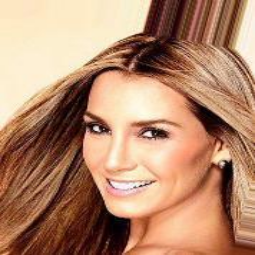

In [3]:
import torchvision as tv
display_trans=tv.transforms.ToPILImage()

# Returns PIL Image from tensor data with pixel RGB values ranging from -1 to 1
def tensorToImage(t):
    display_trans=tv.transforms.ToPILImage()
    return display_trans((t+1)/2)

tensorToImage(celebs[0][0])

In [4]:
# tensor of feature attributes
celebs[0][1]

tensor([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [5]:
import torch
im=celebs[0][0]
im.shape

torch.Size([3, 255, 255])

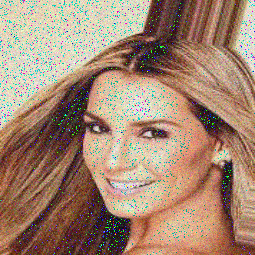

In [6]:
from math import sqrt
# example run of adding gaussian noise to image
var=0.02
im=normal(mean=sqrt(1-sqrt(0.1))*im, std=sqrt(var))

tensorToImage(im)

In [7]:
from math import sqrt
# adds noise to image with var and shifts mean towards 0 using sqrt(1-var)
def add_noise(image, var):
    return normal(mean=sqrt(1-var)*image, std=sqrt(var))


In [8]:
im=celebs[0][0]

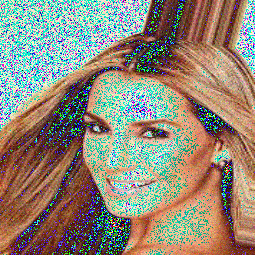

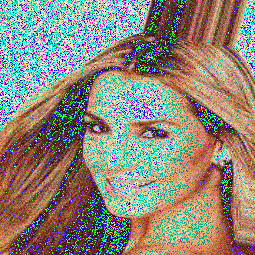

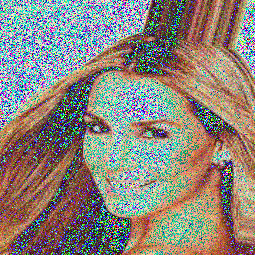

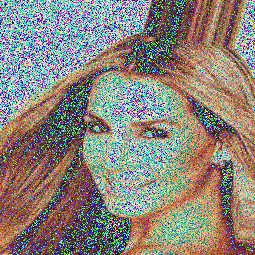

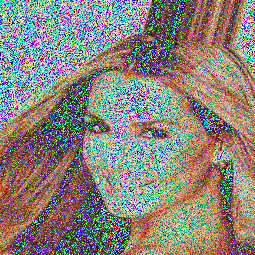

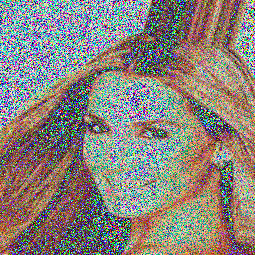

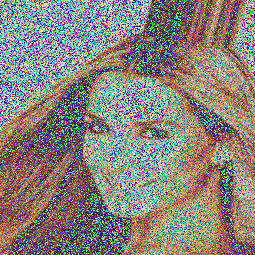

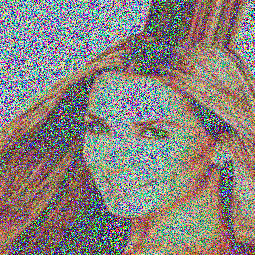

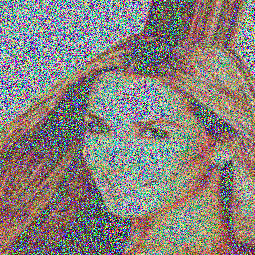

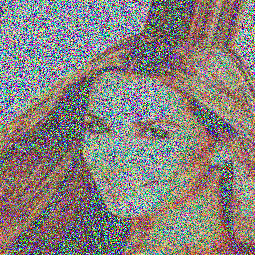

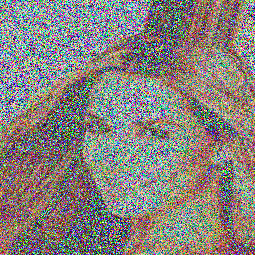

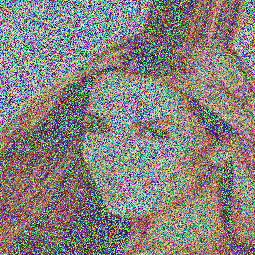

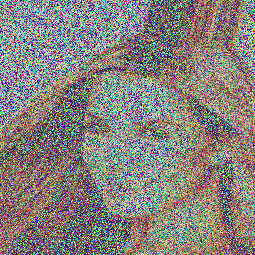

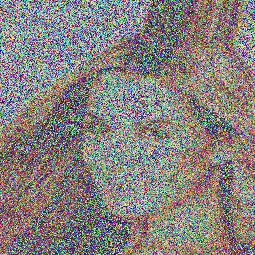

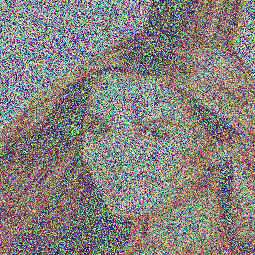

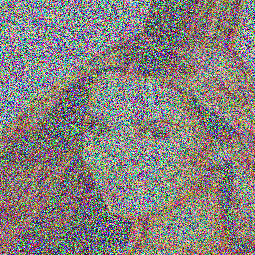

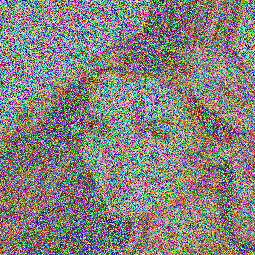

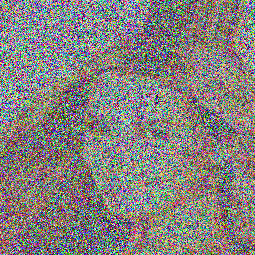

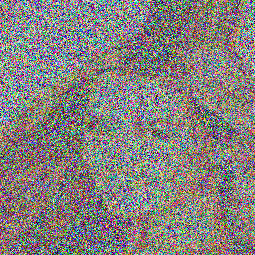

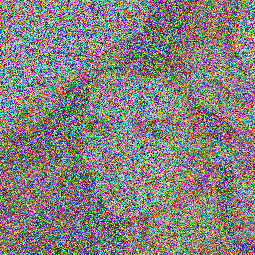

In [9]:
images=[]
for i in range(20):
    im=add_noise(im, 0.02)
    images.append(im)
display(*[tensorToImage(x) for x in images])

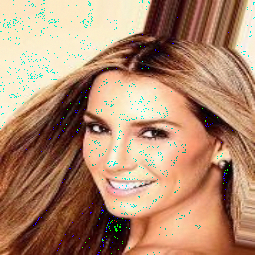

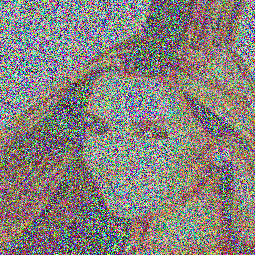

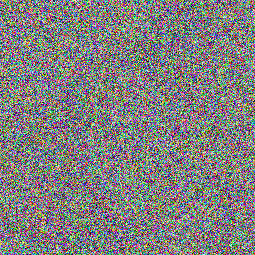

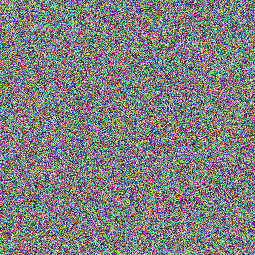

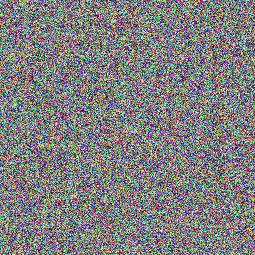

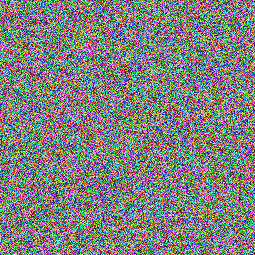

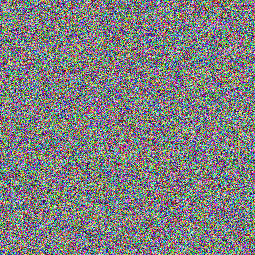

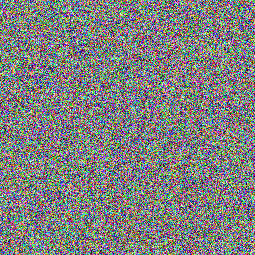

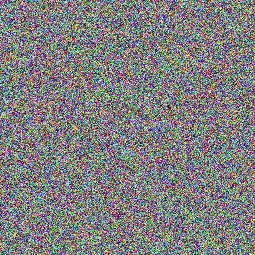

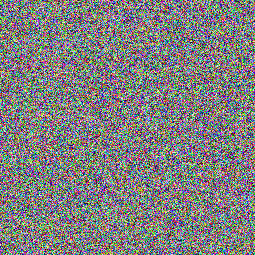

In [10]:
im=celebs[0][0]
# adds gaussian noise to image sequentially following var_scheduler variance
def forward_process(image, var_scheduler=torch.linspace(start=1e-4, end=0.5, steps=100)):
    images=[]
    for var in var_scheduler:
        image=add_noise(image, var)
        images.append(image)
    return images

# puts image through forward process then prints each iteration of process
images=forward_process(im)
display(*[tensorToImage(x) for i, x in enumerate(images) if i%10==0])
    

In [25]:
from torch import nn

# Returns double convolution model with output of shape num_filters x H x W
def double_conv(in_channels, num_filters):
    return 

# Takes in input and number of filters desired and returns output of double convolution with shape N x num_filters x H x W
def conv_block(input, num_filters):
    return nn.Sequential(
        nn.Conv2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=num_filters, out_channels=num_filters, kernel_size=(3, 3), bias=False, padding="same"),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True)
    )


In [26]:
from torch.utils import data

# Getting random samples from celebs dataset
random_sampler = data.RandomSampler(celebs, num_samples=10)
dataloader = data.DataLoader(celebs, batch_size=10, sampler=random_sampler)

# Turning dataloader object into a tensor so it is passable into conv_block for testing
celeb_tensor=tensor([])
for i, d in enumerate(dataloader):
    celeb_tensor=torch.cat((celeb_tensor, d[0]), 0)

for celeb in celeb_tensor:
    print(celeb.shape)

torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])
torch.Size([3, 255, 255])


In [38]:
x1=conv_block(celeb_tensor, 64)(celeb_tensor)
print(x1.shape)
x2=conv_block(x1, 128)(x1)
print(x2.shape)
x3=conv_block(x2, 256)(x2)
print(x3.shape)

torch.Size([10, 64, 255, 255])
torch.Size([10, 128, 255, 255])
torch.Size([10, 256, 255, 255])


In [34]:
def down_block(input, num_filters):
    return nn.Sequential(
        nn.MaxPool2d(kernel_size=(2,2)),
        conv_block(input, num_filters)
    )

layer1=conv_block(celeb_tensor, 64)(celeb_tensor)
layer2=down_block(layer1, 128)(layer1)
layer1.shape, layer2.shape

(torch.Size([10, 64, 255, 255]), torch.Size([10, 128, 127, 127]))

In [39]:
num_filters=64
x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
x2=down_block(x1, num_filters*2)(x1)
x3=down_block(x2, num_filters*4)(x2)
x4=down_block(x3, num_filters*8)(x3)
print(x1.shape, x2.shape, x3.shape, x4.shape)

torch.Size([10, 64, 255, 255]) torch.Size([10, 128, 127, 127]) torch.Size([10, 256, 63, 63]) torch.Size([10, 512, 31, 31])


In [61]:
def up_block(input, skip_connection, num_filters):
    # variables for padding when previous layer was uneven value
    diffH=skip_connection.shape[2]-input.shape[2]*2
    diffW=skip_connection.shape[3]-input.shape[3]*2
    # upsample input
    upsample=nn.ConvTranspose2d(in_channels=input.shape[1], out_channels=num_filters, kernel_size=(2, 2), stride=2, padding=0, output_padding=(diffW-diffW//2, diffH-diffH//2))(input)
    cat=torch.cat([skip_connection, upsample], dim=1)
    return cat, conv_block(cat, num_filters)


In [62]:
# TESTING UPBLOCK
x1=conv_block(celeb_tensor, num_filters)(celeb_tensor)
x2=down_block(x1, num_filters*2)(x1)
x3=down_block(x2, num_filters*4)(x2)
new_input, up_model=up_block(x3, x2, num_filters*2)
print('concatenated input', new_input.shape)
print(up_model(new_input).shape)
print(x1.shape, x2.shape, x3.shape)

1 1
Skip, upsample torch.Size([10, 128, 127, 127]) torch.Size([10, 128, 127, 127])
concatenated input torch.Size([10, 256, 127, 127])
torch.Size([10, 128, 127, 127])
torch.Size([10, 64, 255, 255]) torch.Size([10, 128, 127, 127]) torch.Size([10, 256, 63, 63])


In [23]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
    
    def forward(self, x):
        x1, d1=down_block(x, 64)
        x2, d2=down_block(d1, 128)
        x3, d3=down_block(d2, 256)
        x4, d4=down_block(d3, 512)
        bottom=conv_block(d4, 1024)
        up1=up_block(bottom, x4, 512)
        up2=up_block(up1, x3, 256)
        up3=up_block(up2, x2, 128)
        up4=up_block(up3, x1, 64)
        return nn.Conv2d(in_channels=up4.shape[1], out_channels=up4.shape[1], kernel_size=1)(up4)
    

In [55]:
# loading testing dataset for UNET
from PIL import Image
test_truth=Image.open('./test_unet/testing_groundtruth.tif')
test=Image.open('./test_unet/testing.tif')
train_truth=Image.open('./test_unet/training_groundtruth.tif')
train=Image.open('./test_unet/training.tif')

In [56]:
train=transforms.functional.to_tensor(train)
train_truth=transforms.functional.to_tensor(train_truth)
test=transforms.functional.to_tensor(test)
test_truth=transforms.functional.to_tensor(test_truth)

In [57]:
# splits image into 12 parts and returns list of tensors with the contents of each image
def split_image(im, shape=(3, 4)):
    n=im.shape[1]//shape[0]
    m=im.shape[2]//shape[1]
    return torch.cat([im[:, x:x+n, y:y+m] for x in range(0, im.shape[1], n) for y in range(0, im.shape[2], m)], dim=0)

split=split_image(train, shape=(3, 4))
print(split.shape)

torch.Size([12, 256, 256])


In [58]:
train=split_image(train, shape=(3,4))
train_truth=split_image(train_truth, shape=(3,4))
test=split_image(test, shape=(3,4))
test_truth=split_image(test_truth, shape=(3,4))

In [69]:
temp_model=Unet()
for parameter in temp_model.parameters():
    print(parameter)